In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils
from SpykeTorch import makeInput
import cifar10

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

Files already downloaded and verified
torch.Size([5, 1024, 10])


In [2]:
rf_size = 28 # Receptive field size that will be provided as input to the column
num_neurons = rf_size*rf_size # Number of excitatory neurons in the column
startposition = 0 # Start position of the receptive field w.r.t. top left corner of image
threshold = 75 # Firing threshold for every excitatory neuron
timesteps = 8 # Resolution for timesteps and weights

In [3]:
class PreProcTransform:
    def __init__(self, filter, timesteps = timesteps):
        self.to_tensor = transforms.ToTensor() # Convert to tensor
        self.filter = filter # Apply OnOff filtering
        self.temporal_transform = utils.Intensity2Latency(timesteps) # Convert pixel values to time
                                                    # Higher value corresponds to earlier spiketime
        self.crop = utils.Crop(startposition, rf_size) # Crop the image to form the receptive field
        
    def __call__(self, image):
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0) # Adds a temporal dimension at the beginning
        image = self.filter(image)
        temporal_image = self.temporal_transform(image)
        temporal_image = temporal_image.sign() # This will create spikes
        return self.crop(temporal_image)
    
kernels = [utils.OnKernel(3), utils.OffKernel(3)]
inchannels = len(kernels)

filter = utils.Filter(kernels, padding = 2, thresholds = 50)
preproc = PreProcTransform(filter)

In [4]:
data_root = "data"
MNIST_train = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform = preproc))
MNIST_test = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform = preproc))
MNIST_trainLoader = DataLoader(MNIST_train, batch_size=1000, shuffle=True)
MNIST_testLoader = DataLoader(MNIST_test, batch_size=1000, shuffle=True)

In [11]:
class Column(nn.Module):
    def __init__(self):
        super(Column, self).__init__()
        # Local Convolution layer which creates columns with unique weights (NOT shared weights). The
        # number of columns is based on input_size, kernel_size and stride. Here since we are simulating
        # only one column, the input_size and kernel_size are kept same.
        self.ec = snn.HopfieldNetwork()
        # STDP module which implements the given STDP rule for the above layer (a single column in this case)
        self.stdp = snn.ModSTDP(self.ec, 10/128, 10/128, 1/128, 96/128, 4/128, maxweight = timesteps)
        
    def forward(self, rec_field):
        ### Start of Excitatory Column ###
        out = self.ec(rec_field)
        #spike, pot = sf.fire(out, threshold, True)
        ### End of Excitatory Column ###
        ### Start of Lateral Inhibition ###
        #out = sf.pointwise_inhibition(pot).sign()
        ### End of Lateral Inhibition ###
        return out

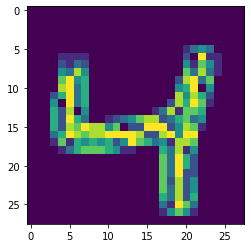

In [12]:
MyColumn=Column()
train_pattern=[torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0),torch.sum(torch.sum(MNIST_train[2][0],dim=0),dim=0)]#[torch.tensor([7,0,0,0,0,7,0,0,0,0,7,0,0,0,0,7]).type(torch.FloatTensor).reshape(4,4)]
MyColumn.ec.train_weights(train_pattern)#[torch.tensor([0,1,2,3,4,5,6,7]*2).reshape(4,4)])#[torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0)])
plt.imshow(train_pattern[1])#torch.tensor([0,1,2,3,4,5,6,7]*2).reshape(4,4))#torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0))
#MyColumn.ec.train_weights([torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0)])
#plt.imshow(torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0))

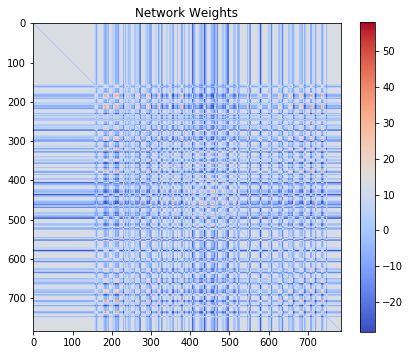

In [13]:
plt.figure(figsize=(6, 5))
w_mat = plt.imshow(MyColumn.ec.W, cmap=cm.coolwarm)
plt.colorbar(w_mat)
plt.title("Network Weights")
plt.tight_layout()
plt.savefig("weights.png")
plt.show()

In [14]:
pattern=torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0).reshape(784)#torch.tensor([0]*784).type(torch.FloatTensor)#torch.tensor([2,6,3,1,7,4,5,2,7,7,7,7,3,7,5,5]).type(torch.FloatTensor)#(torch.tensor([0,1,2,3,4,5,6,7]*2).type(torch.FloatTensor))#torch.sum(torch.sum(MNIST_train[1][0],dim=0),dim=0).reshape(784)-4)/4
out=MyColumn.ec.forward([((pattern-4)/4).clone()],20)

tensor([-1.0000, -0.7500, -0.5000, -0.2500,  0.0000,  0.2500,  0.5000,  0.7500,
         1.0000])
tensor(-2714.4141)
tensor(-0.7694)
tensor([0.2306, 0.0194, 0.2694, 0.5194, 0.7694, 1.0194, 1.2694, 1.5194, 1.7694])
tensor(1)
tensor(-0.7500)
tensor(-6804.3877)
tensor(-1.9287)
tensor([0.9287, 1.1787, 1.4287, 1.6787, 1.9287, 2.1787, 2.4287, 2.6787, 2.9287])
tensor(0)
tensor(-1.)
tensor(-6804.3877)
tensor(-1.9287)
tensor([0.9287, 1.1787, 1.4287, 1.6787, 1.9287, 2.1787, 2.4287, 2.6787, 2.9287])
tensor(0)
tensor(-1.)
tensor(-1886.6609)
tensor(-0.5348)
tensor([0.4652, 0.2152, 0.0348, 0.2848, 0.5348, 0.7848, 1.0348, 1.2848, 1.5348])
tensor(2)
tensor(-0.5000)
tensor(-6805.3892)
tensor(-1.9290)
tensor([0.9290, 1.1790, 1.4290, 1.6790, 1.9290, 2.1790, 2.4290, 2.6790, 2.9290])
tensor(0)
tensor(-1.)
tensor(-6805.3892)
tensor(-1.9290)
tensor([0.9290, 1.1790, 1.4290, 1.6790, 1.9290, 2.1790, 2.4290, 2.6790, 2.9290])
tensor(0)
tensor(-1.)
tensor(-5027.1938)
tensor(-1.4249)
tensor([0.4249, 0.6749, 0.9249,

tensor([0.0687, 0.1813, 0.4313, 0.6813, 0.9313, 1.1813, 1.4313, 1.6813, 1.9313])
tensor(0)
tensor(-1.)
tensor(-5207.4526)
tensor(-1.4760)
tensor([0.4760, 0.7260, 0.9760, 1.2260, 1.4760, 1.7260, 1.9760, 2.2260, 2.4760])
tensor(0)
tensor(-1.)
tensor(-6870.0215)
tensor(-1.9473)
tensor([0.9473, 1.1973, 1.4473, 1.6973, 1.9473, 2.1973, 2.4473, 2.6973, 2.9473])
tensor(0)
tensor(-1.)
tensor(-1858.3152)
tensor(-0.5267)
tensor([0.4733, 0.2233, 0.0267, 0.2767, 0.5267, 0.7767, 1.0267, 1.2767, 1.5267])
tensor(2)
tensor(-0.5000)
tensor(-6871.0234)
tensor(-1.9476)
tensor([0.9476, 1.1976, 1.4476, 1.6976, 1.9476, 2.1976, 2.4476, 2.6976, 2.9476])
tensor(0)
tensor(-1.)
tensor(-6039.0479)
tensor(-1.7117)
tensor([0.7117, 0.9617, 1.2117, 1.4617, 1.7117, 1.9617, 2.2117, 2.4617, 2.7117])
tensor(0)
tensor(-1.)
tensor(-6871.0229)
tensor(-1.9476)
tensor([0.9476, 1.1976, 1.4476, 1.6976, 1.9476, 2.1976, 2.4476, 2.6976, 2.9476])
tensor(0)
tensor(-1.)
tensor(-6871.0229)
tensor(-1.9476)
tensor([0.9476, 1.1976, 1.4476

tensor(2043.0043)
tensor(0.5791)
tensor([1.5791, 1.3291, 1.0791, 0.8291, 0.5791, 0.3291, 0.0791, 0.1709, 0.4209])
tensor(6)
tensor(0.5000)
tensor(-6972.7256)
tensor(-1.9764)
tensor([0.9764, 1.2264, 1.4764, 1.7264, 1.9764, 2.2264, 2.4764, 2.7264, 2.9764])
tensor(0)
tensor(-1.)
tensor(-3529.1084)
tensor(-1.0003)
tensor([3.1412e-04, 2.5031e-01, 5.0031e-01, 7.5031e-01, 1.0003e+00, 1.2503e+00,
        1.5003e+00, 1.7503e+00, 2.0003e+00])
tensor(0)
tensor(-1.)
tensor(-6972.7256)
tensor(-1.9764)
tensor([0.9764, 1.2264, 1.4764, 1.7264, 1.9764, 2.2264, 2.4764, 2.7264, 2.9764])
tensor(0)
tensor(-1.)
tensor(-6972.7256)
tensor(-1.9764)
tensor([0.9764, 1.2264, 1.4764, 1.7264, 1.9764, 2.2264, 2.4764, 2.7264, 2.9764])
tensor(0)
tensor(-1.)
tensor(2046.1362)
tensor(0.5800)
tensor([1.5800, 1.3300, 1.0800, 0.8300, 0.5800, 0.3300, 0.0800, 0.1700, 0.4200])
tensor(6)
tensor(0.5000)
tensor(7376.1475)
tensor(2.0907)
tensor([3.0907, 2.8407, 2.5907, 2.3407, 2.0907, 1.8407, 1.5907, 1.3407, 1.0907])
tensor(8)
te

tensor(-7065.3877)
tensor(-2.0027)
tensor([1.0027, 1.2527, 1.5027, 1.7527, 2.0027, 2.2527, 2.5027, 2.7527, 3.0027])
tensor(0)
tensor(-1.)
tensor(-7065.3877)
tensor(-2.0027)
tensor([1.0027, 1.2527, 1.5027, 1.7527, 2.0027, 2.2527, 2.5027, 2.7527, 3.0027])
tensor(0)
tensor(-1.)
tensor(-7065.3877)
tensor(-2.0027)
tensor([1.0027, 1.2527, 1.5027, 1.7527, 2.0027, 2.2527, 2.5027, 2.7527, 3.0027])
tensor(0)
tensor(-1.)
tensor(-3445.5420)
tensor(-0.9766)
tensor([0.0234, 0.2266, 0.4766, 0.7266, 0.9766, 1.2266, 1.4766, 1.7266, 1.9766])
tensor(0)
tensor(-1.)
tensor(-7069.6211)
tensor(-2.0039)
tensor([1.0039, 1.2539, 1.5039, 1.7539, 2.0039, 2.2539, 2.5039, 2.7539, 3.0039])
tensor(0)
tensor(-1.)
tensor(-7069.6211)
tensor(-2.0039)
tensor([1.0039, 1.2539, 1.5039, 1.7539, 2.0039, 2.2539, 2.5039, 2.7539, 3.0039])
tensor(0)
tensor(-1.)
tensor(-7069.6211)
tensor(-2.0039)
tensor([1.0039, 1.2539, 1.5039, 1.7539, 2.0039, 2.2539, 2.5039, 2.7539, 3.0039])
tensor(0)
tensor(-1.)
tensor(177.7747)
tensor(0.0504)
te

tensor([1.0338, 1.2838, 1.5338, 1.7838, 2.0338, 2.2838, 2.5338, 2.7838, 3.0338])
tensor(0)
tensor(-1.)
tensor(-2521.6667)
tensor(-0.7148)
tensor([0.2852, 0.0352, 0.2148, 0.4648, 0.7148, 0.9648, 1.2148, 1.4648, 1.7148])
tensor(1)
tensor(-0.7500)
tensor(-7175.2563)
tensor(-2.0338)
tensor([1.0338, 1.2838, 1.5338, 1.7838, 2.0338, 2.2838, 2.5338, 2.7838, 3.0338])
tensor(0)
tensor(-1.)
tensor(3692.3708)
tensor(1.0466)
tensor([2.0466, 1.7966, 1.5466, 1.2966, 1.0466, 0.7966, 0.5466, 0.2966, 0.0466])
tensor(8)
tensor(1.)
tensor(3701.5173)
tensor(1.0492)
tensor([2.0492, 1.7992, 1.5492, 1.2992, 1.0492, 0.7992, 0.5492, 0.2992, 0.0492])
tensor(8)
tensor(1.)
tensor(-7177.2598)
tensor(-2.0344)
tensor([1.0344, 1.2844, 1.5344, 1.7844, 2.0344, 2.2844, 2.5344, 2.7844, 3.0344])
tensor(0)
tensor(-1.)
tensor(-7177.2598)
tensor(-2.0344)
tensor([1.0344, 1.2844, 1.5344, 1.7844, 2.0344, 2.2844, 2.5344, 2.7844, 3.0344])
tensor(0)
tensor(-1.)
tensor(-7177.2598)
tensor(-2.0344)
tensor([1.0344, 1.2844, 1.5344, 1.78

tensor([1.0641, 1.3141, 1.5641, 1.8141, 2.0641, 2.3141, 2.5641, 2.8141, 3.0641])
tensor(0)
tensor(-1.)
tensor(-3376.5957)
tensor(-0.9571)
tensor([0.0429, 0.2071, 0.4571, 0.7071, 0.9571, 1.2071, 1.4571, 1.7071, 1.9571])
tensor(0)
tensor(-1.)
tensor(-7282.1670)
tensor(-2.0641)
tensor([1.0641, 1.3141, 1.5641, 1.8141, 2.0641, 2.3141, 2.5641, 2.8141, 3.0641])
tensor(0)
tensor(-1.)
tensor(3554.2510)
tensor(1.0074)
tensor([2.0074, 1.7574, 1.5074, 1.2574, 1.0074, 0.7574, 0.5074, 0.2574, 0.0074])
tensor(8)
tensor(1.)
tensor(-7283.1685)
tensor(-2.0644)
tensor([1.0644, 1.3144, 1.5644, 1.8144, 2.0644, 2.3144, 2.5644, 2.8144, 3.0644])
tensor(0)
tensor(-1.)
tensor(-5478.2017)
tensor(-1.5528)
tensor([0.5528, 0.8028, 1.0528, 1.3028, 1.5528, 1.8028, 2.0528, 2.3028, 2.5528])
tensor(0)
tensor(-1.)
tensor(-7285.9395)
tensor(-2.0652)
tensor([1.0652, 1.3152, 1.5652, 1.8152, 2.0652, 2.3152, 2.5652, 2.8152, 3.0652])
tensor(0)
tensor(-1.)
tensor(-7285.9395)
tensor(-2.0652)
tensor([1.0652, 1.3152, 1.5652, 1.815

tensor([1.0978, 1.3478, 1.5978, 1.8478, 2.0978, 2.3478, 2.5978, 2.8478, 3.0978])
tensor(0)
tensor(-1.)
tensor(7007.5044)
tensor(1.9863)
tensor([2.9863, 2.7363, 2.4863, 2.2363, 1.9863, 1.7363, 1.4863, 1.2363, 0.9863])
tensor(8)
tensor(1.)
tensor(4692.9272)
tensor(1.3302)
tensor([2.3302, 2.0802, 1.8302, 1.5802, 1.3302, 1.0802, 0.8302, 0.5802, 0.3302])
tensor(8)
tensor(1.)
tensor(-7421.4873)
tensor(-2.1036)
tensor([1.1036, 1.3536, 1.6036, 1.8536, 2.1036, 2.3536, 2.6036, 2.8536, 3.1036])
tensor(0)
tensor(-1.)
tensor(-7421.4873)
tensor(-2.1036)
tensor([1.1036, 1.3536, 1.6036, 1.8536, 2.1036, 2.3536, 2.6036, 2.8536, 3.1036])
tensor(0)
tensor(-1.)
tensor(-7421.4873)
tensor(-2.1036)
tensor([1.1036, 1.3536, 1.6036, 1.8536, 2.1036, 2.3536, 2.6036, 2.8536, 3.1036])
tensor(0)
tensor(-1.)
tensor(-7421.4873)
tensor(-2.1036)
tensor([1.1036, 1.3536, 1.6036, 1.8536, 2.1036, 2.3536, 2.6036, 2.8536, 3.1036])
tensor(0)
tensor(-1.)
tensor(-7421.4873)
tensor(-2.1036)
tensor([1.1036, 1.3536, 1.6036, 1.8536, 

tensor(-2.1397)
tensor([1.1397, 1.3897, 1.6397, 1.8897, 2.1397, 2.3897, 2.6397, 2.8897, 3.1397])
tensor(0)
tensor(-1.)
tensor(-7548.8760)
tensor(-2.1397)
tensor([1.1397, 1.3897, 1.6397, 1.8897, 2.1397, 2.3897, 2.6397, 2.8897, 3.1397])
tensor(0)
tensor(-1.)
tensor(3232.4937)
tensor(0.9162)
tensor([1.9162, 1.6662, 1.4162, 1.1662, 0.9162, 0.6662, 0.4162, 0.1662, 0.0838])
tensor(8)
tensor(1.)
tensor(-7549.8779)
tensor(-2.1400)
tensor([1.1400, 1.3900, 1.6400, 1.8900, 2.1400, 2.3900, 2.6400, 2.8900, 3.1400])
tensor(0)
tensor(-1.)
tensor(11174.2666)
tensor(3.1673)
tensor([4.1673, 3.9173, 3.6673, 3.4173, 3.1673, 2.9173, 2.6673, 2.4173, 2.1673])
tensor(8)
tensor(1.)
tensor(3241.6399)
tensor(0.9188)
tensor([1.9188, 1.6688, 1.4188, 1.1688, 0.9188, 0.6688, 0.4188, 0.1688, 0.0812])
tensor(8)
tensor(1.)
tensor(5044.4756)
tensor(1.4298)
tensor([2.4298, 2.1798, 1.9298, 1.6798, 1.4298, 1.1798, 0.9298, 0.6798, 0.4298])
tensor(8)
tensor(1.)
tensor(-7552.0342)
tensor(-2.1406)
tensor([1.1406, 1.3906, 1.640

tensor(-7616.0923)
tensor(-2.1588)
tensor([1.1588, 1.4088, 1.6588, 1.9088, 2.1588, 2.4088, 2.6588, 2.9088, 3.1588])
tensor(0)
tensor(-1.)
tensor(-7616.0923)
tensor(-2.1588)
tensor([1.1588, 1.4088, 1.6588, 1.9088, 2.1588, 2.4088, 2.6588, 2.9088, 3.1588])
tensor(0)
tensor(-1.)
tensor(-5817.5259)
tensor(-1.6490)
tensor([0.6490, 0.8990, 1.1490, 1.3990, 1.6490, 1.8990, 2.1490, 2.3990, 2.6490])
tensor(0)
tensor(-1.)
tensor(-7618.8633)
tensor(-2.1595)
tensor([1.1595, 1.4095, 1.6595, 1.9095, 2.1595, 2.4095, 2.6595, 2.9095, 3.1595])
tensor(0)
tensor(-1.)
tensor(-7618.8633)
tensor(-2.1595)
tensor([1.1595, 1.4095, 1.6595, 1.9095, 2.1595, 2.4095, 2.6595, 2.9095, 3.1595])
tensor(0)
tensor(-1.)
tensor(-7618.8633)
tensor(-2.1595)
tensor([1.1595, 1.4095, 1.6595, 1.9095, 2.1595, 2.4095, 2.6595, 2.9095, 3.1595])
tensor(0)
tensor(-1.)
tensor(-7618.8633)
tensor(-2.1595)
tensor([1.1595, 1.4095, 1.6595, 1.9095, 2.1595, 2.4095, 2.6595, 2.9095, 3.1595])
tensor(0)
tensor(-1.)
tensor(3191.7256)
tensor(0.9047)
t

tensor(0)
tensor(-1.)
tensor(1382.0283)
tensor(0.3917)
tensor([1.3917, 1.1417, 0.8917, 0.6417, 0.3917, 0.1417, 0.1083, 0.3583, 0.6083])
tensor(6)
tensor(0.5000)
tensor(-5882.3174)
tensor(-1.6673)
tensor([0.6673, 0.9173, 1.1673, 1.4173, 1.6673, 1.9173, 2.1673, 2.4173, 2.6673])
tensor(0)
tensor(-1.)
tensor(-7681.1855)
tensor(-2.1772)
tensor([1.1772, 1.4272, 1.6772, 1.9272, 2.1772, 2.4272, 2.6772, 2.9272, 3.1772])
tensor(0)
tensor(-1.)
tensor(-7681.1855)
tensor(-2.1772)
tensor([1.1772, 1.4272, 1.6772, 1.9272, 2.1772, 2.4272, 2.6772, 2.9272, 3.1772])
tensor(0)
tensor(-1.)
tensor(-7681.1855)
tensor(-2.1772)
tensor([1.1772, 1.4272, 1.6772, 1.9272, 2.1772, 2.4272, 2.6772, 2.9272, 3.1772])
tensor(0)
tensor(-1.)
tensor(-7681.1855)
tensor(-2.1772)
tensor([1.1772, 1.4272, 1.6772, 1.9272, 2.1772, 2.4272, 2.6772, 2.9272, 3.1772])
tensor(0)
tensor(-1.)
tensor(-7681.1855)
tensor(-2.1772)
tensor([1.1772, 1.4272, 1.6772, 1.9272, 2.1772, 2.4272, 2.6772, 2.9272, 3.1772])
tensor(0)
tensor(-1.)
tensor(-768

tensor(-1.)
tensor(-7692.9634)
tensor(-2.1805)
tensor([1.1805, 1.4305, 1.6805, 1.9305, 2.1805, 2.4305, 2.6805, 2.9305, 3.1805])
tensor(0)
tensor(-1.)
tensor(6620.3389)
tensor(1.8765)
tensor([2.8765, 2.6265, 2.3765, 2.1265, 1.8765, 1.6265, 1.3765, 1.1265, 0.8765])
tensor(8)
tensor(1.)
tensor(-802.8986)
tensor(-0.2276)
tensor([0.7724, 0.5224, 0.2724, 0.0224, 0.2276, 0.4776, 0.7276, 0.9776, 1.2276])
tensor(3)
tensor(-0.2500)
tensor(-7693.4644)
tensor(-2.1807)
tensor([1.1807, 1.4307, 1.6807, 1.9307, 2.1807, 2.4307, 2.6807, 2.9307, 3.1807])
tensor(0)
tensor(-1.)
tensor(-7693.4644)
tensor(-2.1807)
tensor([1.1807, 1.4307, 1.6807, 1.9307, 2.1807, 2.4307, 2.6807, 2.9307, 3.1807])
tensor(0)
tensor(-1.)
tensor(-7693.4644)
tensor(-2.1807)
tensor([1.1807, 1.4307, 1.6807, 1.9307, 2.1807, 2.4307, 2.6807, 2.9307, 3.1807])
tensor(0)
tensor(-1.)
tensor(-7693.4644)
tensor(-2.1807)
tensor([1.1807, 1.4307, 1.6807, 1.9307, 2.1807, 2.4307, 2.6807, 2.9307, 3.1807])
tensor(0)
tensor(-1.)
tensor(4829.6699)
tens

tensor(6)
tensor(0.5000)
tensor(-7701.9707)
tensor(-2.1831)
tensor([1.1831, 1.4331, 1.6831, 1.9331, 2.1831, 2.4331, 2.6831, 2.9331, 3.1831])
tensor(0)
tensor(-1.)
tensor(-7701.9707)
tensor(-2.1831)
tensor([1.1831, 1.4331, 1.6831, 1.9331, 2.1831, 2.4331, 2.6831, 2.9331, 3.1831])
tensor(0)
tensor(-1.)
tensor(-4228.0781)
tensor(-1.1984)
tensor([0.1984, 0.4484, 0.6984, 0.9484, 1.1984, 1.4484, 1.6984, 1.9484, 2.1984])
tensor(0)
tensor(-1.)
tensor(-7701.9707)
tensor(-2.1831)
tensor([1.1831, 1.4331, 1.6831, 1.9331, 2.1831, 2.4331, 2.6831, 2.9331, 3.1831])
tensor(0)
tensor(-1.)
tensor(-7701.9707)
tensor(-2.1831)
tensor([1.1831, 1.4331, 1.6831, 1.9331, 2.1831, 2.4331, 2.6831, 2.9331, 3.1831])
tensor(0)
tensor(-1.)
tensor(-5388.0420)
tensor(-1.5272)
tensor([0.5272, 0.7772, 1.0272, 1.2772, 1.5272, 1.7772, 2.0272, 2.2772, 2.5272])
tensor(0)
tensor(-1.)
tensor(3537.1631)
tensor(1.0026)
tensor([2.0026, 1.7526, 1.5026, 1.2526, 1.0026, 0.7526, 0.5026, 0.2526, 0.0026])
tensor(8)
tensor(1.)
tensor(4772.

tensor(-1.)
tensor(10529.5312)
tensor(2.9846)
tensor([3.9846, 3.7346, 3.4846, 3.2346, 2.9846, 2.7346, 2.4846, 2.2346, 1.9846])
tensor(8)
tensor(1.)
tensor(-7715.2109)
tensor(-2.1869)
tensor([1.1869, 1.4369, 1.6869, 1.9369, 2.1869, 2.4369, 2.6869, 2.9369, 3.1869])
tensor(0)
tensor(-1.)
tensor(-7715.2109)
tensor(-2.1869)
tensor([1.1869, 1.4369, 1.6869, 1.9369, 2.1869, 2.4369, 2.6869, 2.9369, 3.1869])
tensor(0)
tensor(-1.)
tensor(-7715.2109)
tensor(-2.1869)
tensor([1.1869, 1.4369, 1.6869, 1.9369, 2.1869, 2.4369, 2.6869, 2.9369, 3.1869])
tensor(0)
tensor(-1.)
tensor(1149.0908)
tensor(0.3257)
tensor([1.3257, 1.0757, 0.8257, 0.5757, 0.3257, 0.0757, 0.1743, 0.4243, 0.6743])
tensor(5)
tensor(0.2500)
tensor(-7715.3647)
tensor(-2.1869)
tensor([1.1869, 1.4369, 1.6869, 1.9369, 2.1869, 2.4369, 2.6869, 2.9369, 3.1869])
tensor(0)
tensor(-1.)
tensor(-7715.3647)
tensor(-2.1869)
tensor([1.1869, 1.4369, 1.6869, 1.9369, 2.1869, 2.4369, 2.6869, 2.9369, 3.1869])
tensor(0)
tensor(-1.)
tensor(-7715.3643)
tens

tensor(-2.1886)
tensor([1.1886, 1.4386, 1.6886, 1.9386, 2.1886, 2.4386, 2.6886, 2.9386, 3.1886])
tensor(0)
tensor(-1.)
tensor(-598.4901)
tensor(-0.1696)
tensor([0.8304, 0.5804, 0.3304, 0.0804, 0.1696, 0.4196, 0.6696, 0.9196, 1.1696])
tensor(3)
tensor(-0.2500)
tensor(-7721.9082)
tensor(-2.1887)
tensor([1.1887, 1.4387, 1.6887, 1.9387, 2.1887, 2.4387, 2.6887, 2.9387, 3.1887])
tensor(0)
tensor(-1.)
tensor(-7721.9082)
tensor(-2.1887)
tensor([1.1887, 1.4387, 1.6887, 1.9387, 2.1887, 2.4387, 2.6887, 2.9387, 3.1887])
tensor(0)
tensor(-1.)
tensor(-7721.9082)
tensor(-2.1887)
tensor([1.1887, 1.4387, 1.6887, 1.9387, 2.1887, 2.4387, 2.6887, 2.9387, 3.1887])
tensor(0)
tensor(-1.)
tensor(-668.5786)
tensor(-0.1895)
tensor([0.8105, 0.5605, 0.3105, 0.0605, 0.1895, 0.4395, 0.6895, 0.9395, 1.1895])
tensor(3)
tensor(-0.2500)
tensor(-7722.7158)
tensor(-2.1890)
tensor([1.1890, 1.4390, 1.6890, 1.9390, 2.1890, 2.4390, 2.6890, 2.9390, 3.1890])
tensor(0)
tensor(-1.)
tensor(-7722.7158)
tensor(-2.1890)
tensor([1.18

tensor([1.5323, 1.2823, 1.0323, 0.7823, 0.5323, 0.2823, 0.0323, 0.2177, 0.4677])
tensor(6)
tensor(0.5000)
tensor(6255.8672)
tensor(1.7732)
tensor([2.7732, 2.5232, 2.2732, 2.0232, 1.7732, 1.5232, 1.2732, 1.0232, 0.7732])
tensor(8)
tensor(1.)
tensor(-7735.6089)
tensor(-2.1926)
tensor([1.1926, 1.4426, 1.6926, 1.9426, 2.1926, 2.4426, 2.6926, 2.9426, 3.1926])
tensor(0)
tensor(-1.)
tensor(2434.2786)
tensor(0.6900)
tensor([1.6900, 1.4400, 1.1900, 0.9400, 0.6900, 0.4400, 0.1900, 0.0600, 0.3100])
tensor(7)
tensor(0.7500)
tensor(-7737.4180)
tensor(-2.1931)
tensor([1.1931, 1.4431, 1.6931, 1.9431, 2.1931, 2.4431, 2.6931, 2.9431, 3.1931])
tensor(0)
tensor(-1.)
tensor(-2915.4749)
tensor(-0.8264)
tensor([0.1736, 0.0764, 0.3264, 0.5764, 0.8264, 1.0764, 1.3264, 1.5764, 1.8264])
tensor(1)
tensor(-0.7500)
tensor(-7736.6104)
tensor(-2.1929)
tensor([1.1929, 1.4429, 1.6929, 1.9429, 2.1929, 2.4429, 2.6929, 2.9429, 3.1929])
tensor(0)
tensor(-1.)
tensor(11079.6006)
tensor(3.1405)
tensor([4.1405, 3.8905, 3.6405

tensor(-2.1962)
tensor([1.1962, 1.4462, 1.6962, 1.9462, 2.1962, 2.4462, 2.6962, 2.9462, 3.1962])
tensor(0)
tensor(-1.)
tensor(-7748.3154)
tensor(-2.1962)
tensor([1.1962, 1.4462, 1.6962, 1.9462, 2.1962, 2.4462, 2.6962, 2.9462, 3.1962])
tensor(0)
tensor(-1.)
tensor(-4267.9297)
tensor(-1.2097)
tensor([0.2097, 0.4597, 0.7097, 0.9597, 1.2097, 1.4597, 1.7097, 1.9597, 2.2097])
tensor(0)
tensor(-1.)
tensor(-7748.3154)
tensor(-2.1962)
tensor([1.1962, 1.4462, 1.6962, 1.9462, 2.1962, 2.4462, 2.6962, 2.9462, 3.1962])
tensor(0)
tensor(-1.)
tensor(-7748.3154)
tensor(-2.1962)
tensor([1.1962, 1.4462, 1.6962, 1.9462, 2.1962, 2.4462, 2.6962, 2.9462, 3.1962])
tensor(0)
tensor(-1.)
tensor(-7748.3154)
tensor(-2.1962)
tensor([1.1962, 1.4462, 1.6962, 1.9462, 2.1962, 2.4462, 2.6962, 2.9462, 3.1962])
tensor(0)
tensor(-1.)
tensor(-7748.3154)
tensor(-2.1962)
tensor([1.1962, 1.4462, 1.6962, 1.9462, 2.1962, 2.4462, 2.6962, 2.9462, 3.1962])
tensor(0)
tensor(-1.)
tensor(613.5475)
tensor(0.1739)
tensor([1.1739, 0.923

tensor(-2.1986)
tensor([1.1986, 1.4486, 1.6986, 1.9486, 2.1986, 2.4486, 2.6986, 2.9486, 3.1986])
tensor(0)
tensor(-1.)
tensor(-7756.5947)
tensor(-2.1986)
tensor([1.1986, 1.4486, 1.6986, 1.9486, 2.1986, 2.4486, 2.6986, 2.9486, 3.1986])
tensor(0)
tensor(-1.)
tensor(-7756.5947)
tensor(-2.1986)
tensor([1.1986, 1.4486, 1.6986, 1.9486, 2.1986, 2.4486, 2.6986, 2.9486, 3.1986])
tensor(0)
tensor(-1.)
tensor(-7756.5947)
tensor(-2.1986)
tensor([1.1986, 1.4486, 1.6986, 1.9486, 2.1986, 2.4486, 2.6986, 2.9486, 3.1986])
tensor(0)
tensor(-1.)
tensor(-7756.5947)
tensor(-2.1986)
tensor([1.1986, 1.4486, 1.6986, 1.9486, 2.1986, 2.4486, 2.6986, 2.9486, 3.1986])
tensor(0)
tensor(-1.)
tensor(-7756.5947)
tensor(-2.1986)
tensor([1.1986, 1.4486, 1.6986, 1.9486, 2.1986, 2.4486, 2.6986, 2.9486, 3.1986])
tensor(0)
tensor(-1.)
tensor(-7756.5947)
tensor(-2.1986)
tensor([1.1986, 1.4486, 1.6986, 1.9486, 2.1986, 2.4486, 2.6986, 2.9486, 3.1986])
tensor(0)
tensor(-1.)
tensor(-6524.4463)
tensor(-1.8493)
tensor([0.8493, 1.

tensor(-2.2011)
tensor([1.2011, 1.4511, 1.7011, 1.9511, 2.2011, 2.4511, 2.7011, 2.9511, 3.2011])
tensor(0)
tensor(-1.)
tensor(-3551.1763)
tensor(-1.0066)
tensor([0.0066, 0.2566, 0.5066, 0.7566, 1.0066, 1.2566, 1.5066, 1.7566, 2.0066])
tensor(0)
tensor(-1.)
tensor(-4333.2666)
tensor(-1.2283)
tensor([0.2283, 0.4783, 0.7283, 0.9783, 1.2283, 1.4783, 1.7283, 1.9783, 2.2283])
tensor(0)
tensor(-1.)
tensor(2243.4531)
tensor(0.6359)
tensor([1.6359, 1.3859, 1.1359, 0.8859, 0.6359, 0.3859, 0.1359, 0.1141, 0.3641])
tensor(7)
tensor(0.7500)
tensor(-7770.8765)
tensor(-2.2026)
tensor([1.2026, 1.4526, 1.7026, 1.9526, 2.2026, 2.4526, 2.7026, 2.9526, 3.2026])
tensor(0)
tensor(-1.)
tensor(-5263.6211)
tensor(-1.4920)
tensor([0.4920, 0.7420, 0.9920, 1.2420, 1.4920, 1.7420, 1.9920, 2.2420, 2.4920])
tensor(0)
tensor(-1.)
tensor(-2628.9922)
tensor(-0.7452)
tensor([0.2548, 0.0048, 0.2452, 0.4952, 0.7452, 0.9952, 1.2452, 1.4952, 1.7452])
tensor(1)
tensor(-0.7500)
tensor(-7772.3389)
tensor(-2.2030)
tensor([1.203

tensor(-1.)
tensor(-7777.0728)
tensor(-2.2044)
tensor([1.2044, 1.4544, 1.7044, 1.9544, 2.2044, 2.4544, 2.7044, 2.9544, 3.2044])
tensor(0)
tensor(-1.)
tensor(-7777.0728)
tensor(-2.2044)
tensor([1.2044, 1.4544, 1.7044, 1.9544, 2.2044, 2.4544, 2.7044, 2.9544, 3.2044])
tensor(0)
tensor(-1.)
tensor(4157.8652)
tensor(1.1785)
tensor([2.1785, 1.9285, 1.6785, 1.4285, 1.1785, 0.9285, 0.6785, 0.4285, 0.1785])
tensor(8)
tensor(1.)
tensor(-4362.2002)
tensor(-1.2365)
tensor([0.2365, 0.4865, 0.7365, 0.9865, 1.2365, 1.4865, 1.7365, 1.9865, 2.2365])
tensor(0)
tensor(-1.)
tensor(-7777.0723)
tensor(-2.2044)
tensor([1.2044, 1.4544, 1.7044, 1.9544, 2.2044, 2.4544, 2.7044, 2.9544, 3.2044])
tensor(0)
tensor(-1.)
tensor(-4362.2002)
tensor(-1.2365)
tensor([0.2365, 0.4865, 0.7365, 0.9865, 1.2365, 1.4865, 1.7365, 1.9865, 2.2365])
tensor(0)
tensor(-1.)
tensor(2454.9590)
tensor(0.6959)
tensor([1.6959, 1.4459, 1.1959, 0.9459, 0.6959, 0.4459, 0.1959, 0.0541, 0.3041])
tensor(7)
tensor(0.7500)
tensor(-948.7814)
tensor

tensor(-2.2054)
tensor([1.2054, 1.4554, 1.7054, 1.9554, 2.2054, 2.4554, 2.7054, 2.9554, 3.2054])
tensor(0)
tensor(-1.)
tensor(-7780.6914)
tensor(-2.2054)
tensor([1.2054, 1.4554, 1.7054, 1.9554, 2.2054, 2.4554, 2.7054, 2.9554, 3.2054])
tensor(0)
tensor(-1.)
tensor(-7780.6914)
tensor(-2.2054)
tensor([1.2054, 1.4554, 1.7054, 1.9554, 2.2054, 2.4554, 2.7054, 2.9554, 3.2054])
tensor(0)
tensor(-1.)
tensor(-7780.6914)
tensor(-2.2054)
tensor([1.2054, 1.4554, 1.7054, 1.9554, 2.2054, 2.4554, 2.7054, 2.9554, 3.2054])
tensor(0)
tensor(-1.)
tensor(-7780.6914)
tensor(-2.2054)
tensor([1.2054, 1.4554, 1.7054, 1.9554, 2.2054, 2.4554, 2.7054, 2.9554, 3.2054])
tensor(0)
tensor(-1.)
tensor(-5244.9365)
tensor(-1.4867)
tensor([0.4867, 0.7367, 0.9867, 1.2367, 1.4867, 1.7367, 1.9867, 2.2367, 2.4867])
tensor(0)
tensor(-1.)
tensor(-7780.6914)
tensor(-2.2054)
tensor([1.2054, 1.4554, 1.7054, 1.9554, 2.2054, 2.4554, 2.7054, 2.9554, 3.2054])
tensor(0)
tensor(-1.)
tensor(736.7869)
tensor(0.2088)
tensor([1.2088, 0.958

tensor(0)
tensor(-1.)
tensor(1122.2827)
tensor(0.3181)
tensor([1.3181, 1.0681, 0.8181, 0.5681, 0.3181, 0.0681, 0.1819, 0.4319, 0.6819])
tensor(5)
tensor(0.2500)
tensor(11754.1152)
tensor(3.3317)
tensor([4.3317, 4.0817, 3.8317, 3.5817, 3.3317, 3.0817, 2.8317, 2.5817, 2.3317])
tensor(8)
tensor(1.)
tensor(-7785.9663)
tensor(-2.2069)
tensor([1.2069, 1.4569, 1.7069, 1.9569, 2.2069, 2.4569, 2.7069, 2.9569, 3.2069])
tensor(0)
tensor(-1.)
tensor(-7785.9663)
tensor(-2.2069)
tensor([1.2069, 1.4569, 1.7069, 1.9569, 2.2069, 2.4569, 2.7069, 2.9569, 3.2069])
tensor(0)
tensor(-1.)
tensor(-7785.9663)
tensor(-2.2069)
tensor([1.2069, 1.4569, 1.7069, 1.9569, 2.2069, 2.4569, 2.7069, 2.9569, 3.2069])
tensor(0)
tensor(-1.)
tensor(-7785.9663)
tensor(-2.2069)
tensor([1.2069, 1.4569, 1.7069, 1.9569, 2.2069, 2.4569, 2.7069, 2.9569, 3.2069])
tensor(0)
tensor(-1.)
tensor(-7785.9663)
tensor(-2.2069)
tensor([1.2069, 1.4569, 1.7069, 1.9569, 2.2069, 2.4569, 2.7069, 2.9569, 3.2069])
tensor(0)
tensor(-1.)
tensor(-979.4

tensor(-1.)
tensor(4068.0994)
tensor(1.1531)
tensor([2.1531, 1.9031, 1.6531, 1.4031, 1.1531, 0.9031, 0.6531, 0.4031, 0.1531])
tensor(8)
tensor(1.)
tensor(690.5785)
tensor(0.1957)
tensor([1.1957, 0.9457, 0.6957, 0.4457, 0.1957, 0.0543, 0.3043, 0.5543, 0.8043])
tensor(5)
tensor(0.2500)
tensor(-1387.5260)
tensor(-0.3933)
tensor([0.6067, 0.3567, 0.1067, 0.1433, 0.3933, 0.6433, 0.8933, 1.1433, 1.3933])
tensor(2)
tensor(-0.5000)
tensor(-7793.7046)
tensor(-2.2091)
tensor([1.2091, 1.4591, 1.7091, 1.9591, 2.2091, 2.4591, 2.7091, 2.9591, 3.2091])
tensor(0)
tensor(-1.)
tensor(14307.7637)
tensor(4.0555)
tensor([5.0555, 4.8055, 4.5555, 4.3055, 4.0555, 3.8055, 3.5555, 3.3055, 3.0555])
tensor(8)
tensor(1.)
tensor(-7793.7051)
tensor(-2.2091)
tensor([1.2091, 1.4591, 1.7091, 1.9591, 2.2091, 2.4591, 2.7091, 2.9591, 3.2091])
tensor(0)
tensor(-1.)
tensor(-2667.7510)
tensor(-0.7562)
tensor([0.2438, 0.0062, 0.2562, 0.5062, 0.7562, 1.0062, 1.2562, 1.5062, 1.7562])
tensor(1)
tensor(-0.7500)
tensor(2863.5417)
t

tensor([0.2532, 0.5032, 0.7532, 1.0032, 1.2532, 1.5032, 1.7532, 2.0032, 2.2532])
tensor(0)
tensor(-1.)
tensor(9676.5742)
tensor(2.7428)
tensor([3.7428, 3.4928, 3.2428, 2.9928, 2.7428, 2.4928, 2.2428, 1.9928, 1.7428])
tensor(8)
tensor(1.)
tensor(-7804.1006)
tensor(-2.2120)
tensor([1.2120, 1.4620, 1.7120, 1.9620, 2.2120, 2.4620, 2.7120, 2.9620, 3.2120])
tensor(0)
tensor(-1.)
tensor(-7804.1006)
tensor(-2.2120)
tensor([1.2120, 1.4620, 1.7120, 1.9620, 2.2120, 2.4620, 2.7120, 2.9620, 3.2120])
tensor(0)
tensor(-1.)
tensor(-7804.1006)
tensor(-2.2120)
tensor([1.2120, 1.4620, 1.7120, 1.9620, 2.2120, 2.4620, 2.7120, 2.9620, 3.2120])
tensor(0)
tensor(-1.)
tensor(-7804.1011)
tensor(-2.2120)
tensor([1.2120, 1.4620, 1.7120, 1.9620, 2.2120, 2.4620, 2.7120, 2.9620, 3.2120])
tensor(0)
tensor(-1.)
tensor(-7804.1011)
tensor(-2.2120)
tensor([1.2120, 1.4620, 1.7120, 1.9620, 2.2120, 2.4620, 2.7120, 2.9620, 3.2120])
tensor(0)
tensor(-1.)
tensor(-7804.1011)
tensor(-2.2120)
tensor([1.2120, 1.4620, 1.7120, 1.962

tensor(-1.1125)
tensor([0.1125, 0.3625, 0.6125, 0.8625, 1.1125, 1.3625, 1.6125, 1.8625, 2.1125])
tensor(0)
tensor(-1.)
tensor(-7804.6016)
tensor(-2.2122)
tensor([1.2122, 1.4622, 1.7122, 1.9622, 2.2122, 2.4622, 2.7122, 2.9622, 3.2122])
tensor(0)
tensor(-1.)
tensor(5679.3135)
tensor(1.6098)
tensor([2.6098, 2.3598, 2.1098, 1.8598, 1.6098, 1.3598, 1.1098, 0.8598, 0.6098])
tensor(8)
tensor(1.)
tensor(-7804.6016)
tensor(-2.2122)
tensor([1.2122, 1.4622, 1.7122, 1.9622, 2.2122, 2.4622, 2.7122, 2.9622, 3.2122])
tensor(0)
tensor(-1.)
tensor(-7804.6016)
tensor(-2.2122)
tensor([1.2122, 1.4622, 1.7122, 1.9622, 2.2122, 2.4622, 2.7122, 2.9622, 3.2122])
tensor(0)
tensor(-1.)
tensor(-7804.6016)
tensor(-2.2122)
tensor([1.2122, 1.4622, 1.7122, 1.9622, 2.2122, 2.4622, 2.7122, 2.9622, 3.2122])
tensor(0)
tensor(-1.)
tensor(-7804.6016)
tensor(-2.2122)
tensor([1.2122, 1.4622, 1.7122, 1.9622, 2.2122, 2.4622, 2.7122, 2.9622, 3.2122])
tensor(0)
tensor(-1.)
tensor(-7804.6016)
tensor(-2.2122)
tensor([1.2122, 1.462

tensor(0.2500)
tensor(-7804.7949)
tensor(-2.2122)
tensor([1.2122, 1.4622, 1.7122, 1.9622, 2.2122, 2.4622, 2.7122, 2.9622, 3.2122])
tensor(0)
tensor(-1.)
tensor(-1324.8982)
tensor(-0.3755)
tensor([0.6245, 0.3745, 0.1245, 0.1255, 0.3755, 0.6255, 0.8755, 1.1255, 1.3755])
tensor(2)
tensor(-0.5000)
tensor(-7804.7949)
tensor(-2.2122)
tensor([1.2122, 1.4622, 1.7122, 1.9622, 2.2122, 2.4622, 2.7122, 2.9622, 3.2122])
tensor(0)
tensor(-1.)
tensor(-4431.8311)
tensor(-1.2562)
tensor([0.2562, 0.5062, 0.7562, 1.0062, 1.2562, 1.5062, 1.7562, 2.0062, 2.2562])
tensor(0)
tensor(-1.)
tensor(2306.0854)
tensor(0.6537)
tensor([1.6537, 1.4037, 1.1537, 0.9037, 0.6537, 0.4037, 0.1537, 0.0963, 0.3463])
tensor(7)
tensor(0.7500)
tensor(2306.0854)
tensor(0.6537)
tensor([1.6537, 1.4037, 1.1537, 0.9037, 0.6537, 0.4037, 0.1537, 0.0963, 0.3463])
tensor(7)
tensor(0.7500)
tensor(5663.4160)
tensor(1.6053)
tensor([2.6053, 2.3553, 2.1053, 1.8553, 1.6053, 1.3553, 1.1053, 0.8553, 0.6053])
tensor(8)
tensor(1.)
tensor(-7804.794

tensor(-0.7500)
tensor(-7807.2988)
tensor(-2.2130)
tensor([1.2130, 1.4630, 1.7130, 1.9630, 2.2130, 2.4630, 2.7130, 2.9630, 3.2130])
tensor(0)
tensor(-1.)
tensor(-7807.2988)
tensor(-2.2130)
tensor([1.2130, 1.4630, 1.7130, 1.9630, 2.2130, 2.4630, 2.7130, 2.9630, 3.2130])
tensor(0)
tensor(-1.)
tensor(372.9210)
tensor(0.1057)
tensor([1.1057, 0.8557, 0.6057, 0.3557, 0.1057, 0.1443, 0.3943, 0.6443, 0.8943])
tensor(4)
tensor(0.)
tensor(-7807.2988)
tensor(-2.2130)
tensor([1.2130, 1.4630, 1.7130, 1.9630, 2.2130, 2.4630, 2.7130, 2.9630, 3.2130])
tensor(0)
tensor(-1.)
tensor(-4440.3779)
tensor(-1.2586)
tensor([0.2586, 0.5086, 0.7586, 1.0086, 1.2586, 1.5086, 1.7586, 2.0086, 2.2586])
tensor(0)
tensor(-1.)
tensor(-6510.0889)
tensor(-1.8453)
tensor([0.8453, 1.0953, 1.3453, 1.5953, 1.8453, 2.0953, 2.3453, 2.5953, 2.8453])
tensor(0)
tensor(-1.)
tensor(6569.1675)
tensor(1.8620)
tensor([2.8620, 2.6120, 2.3620, 2.1120, 1.8620, 1.6120, 1.3620, 1.1120, 0.8620])
tensor(8)
tensor(1.)
tensor(1289.1165)
tensor(

tensor(0)
tensor(-1.)
tensor(-1283.9539)
tensor(-0.3639)
tensor([0.6361, 0.3861, 0.1361, 0.1139, 0.3639, 0.6139, 0.8639, 1.1139, 1.3639])
tensor(3)
tensor(-0.2500)
tensor(5595.9355)
tensor(1.5861)
tensor([2.5861, 2.3361, 2.0861, 1.8361, 1.5861, 1.3361, 1.0861, 0.8361, 0.5861])
tensor(8)
tensor(1.)
tensor(3923.5864)
tensor(1.1121)
tensor([2.1121, 1.8621, 1.6121, 1.3621, 1.1121, 0.8621, 0.6121, 0.3621, 0.1121])
tensor(8)
tensor(1.)
tensor(-7811.4585)
tensor(-2.2141)
tensor([1.2141, 1.4641, 1.7141, 1.9641, 2.2141, 2.4641, 2.7141, 2.9641, 3.2141])
tensor(0)
tensor(-1.)
tensor(-7811.4590)
tensor(-2.2141)
tensor([1.2141, 1.4641, 1.7141, 1.9641, 2.2141, 2.4641, 2.7141, 2.9641, 3.2141])
tensor(0)
tensor(-1.)
tensor(-4453.6982)
tensor(-1.2624)
tensor([0.2624, 0.5124, 0.7624, 1.0124, 1.2624, 1.5124, 1.7624, 2.0124, 2.2624])
tensor(0)
tensor(-1.)
tensor(-7811.4590)
tensor(-2.2141)
tensor([1.2141, 1.4641, 1.7141, 1.9641, 2.2141, 2.4641, 2.7141, 2.9641, 3.2141])
tensor(0)
tensor(-1.)
tensor(6907.78

tensor(9152.8535)
tensor(2.5943)
tensor([3.5943, 3.3443, 3.0943, 2.8443, 2.5943, 2.3443, 2.0943, 1.8443, 1.5943])
tensor(8)
tensor(1.)
tensor(-7810.9980)
tensor(-2.2140)
tensor([1.2140, 1.4640, 1.7140, 1.9640, 2.2140, 2.4640, 2.7140, 2.9640, 3.2140])
tensor(0)
tensor(-1.)
tensor(-7810.9980)
tensor(-2.2140)
tensor([1.2140, 1.4640, 1.7140, 1.9640, 2.2140, 2.4640, 2.7140, 2.9640, 3.2140])
tensor(0)
tensor(-1.)
tensor(-2778.9958)
tensor(-0.7877)
tensor([0.2123, 0.0377, 0.2877, 0.5377, 0.7877, 1.0377, 1.2877, 1.5377, 1.7877])
tensor(1)
tensor(-0.7500)
tensor(2242.4922)
tensor(0.6356)
tensor([1.6356, 1.3856, 1.1356, 0.8856, 0.6356, 0.3856, 0.1356, 0.1144, 0.3644])
tensor(7)
tensor(0.7500)
tensor(-7810.9980)
tensor(-2.2140)
tensor([1.2140, 1.4640, 1.7140, 1.9640, 2.2140, 2.4640, 2.7140, 2.9640, 3.2140])
tensor(0)
tensor(-1.)
tensor(-2214.2703)
tensor(-0.6276)
tensor([0.3724, 0.1224, 0.1276, 0.3776, 0.6276, 0.8776, 1.1276, 1.3776, 1.6276])
tensor(1)
tensor(-0.7500)
tensor(2822.5701)
tensor(0.8

tensor(1.)
tensor(-7810.9980)
tensor(-2.2140)
tensor([1.2140, 1.4640, 1.7140, 1.9640, 2.2140, 2.4640, 2.7140, 2.9640, 3.2140])
tensor(0)
tensor(-1.)
tensor(2623.6477)
tensor(0.7437)
tensor([1.7437, 1.4937, 1.2437, 0.9937, 0.7437, 0.4937, 0.2437, 0.0063, 0.2563])
tensor(7)
tensor(0.7500)
tensor(-5198.6636)
tensor(-1.4735)
tensor([0.4735, 0.7235, 0.9735, 1.2235, 1.4735, 1.7235, 1.9735, 2.2235, 2.4735])
tensor(0)
tensor(-1.)
tensor(-2778.9958)
tensor(-0.7877)
tensor([0.2123, 0.0377, 0.2877, 0.5377, 0.7877, 1.0377, 1.2877, 1.5377, 1.7877])
tensor(1)
tensor(-0.7500)
tensor(-7810.9980)
tensor(-2.2140)
tensor([1.2140, 1.4640, 1.7140, 1.9640, 2.2140, 2.4640, 2.7140, 2.9640, 3.2140])
tensor(0)
tensor(-1.)
tensor(-3889.4966)
tensor(-1.1025)
tensor([0.1025, 0.3525, 0.6025, 0.8525, 1.1025, 1.3525, 1.6025, 1.8525, 2.1025])
tensor(0)
tensor(-1.)
tensor(-7810.9980)
tensor(-2.2140)
tensor([1.2140, 1.4640, 1.7140, 1.9640, 2.2140, 2.4640, 2.7140, 2.9640, 3.2140])
tensor(0)
tensor(-1.)
tensor(-7810.9980)

tensor(3.8057)
tensor([4.8057, 4.5557, 4.3057, 4.0557, 3.8057, 3.5557, 3.3057, 3.0557, 2.8057])
tensor(8)
tensor(1.)
tensor(-7811.5386)
tensor(-2.2142)
tensor([1.2142, 1.4642, 1.7142, 1.9642, 2.2142, 2.4642, 2.7142, 2.9642, 3.2142])
tensor(0)
tensor(-1.)
tensor(-7811.5391)
tensor(-2.2142)
tensor([1.2142, 1.4642, 1.7142, 1.9642, 2.2142, 2.4642, 2.7142, 2.9642, 3.2142])
tensor(0)
tensor(-1.)
tensor(-2789.3518)
tensor(-0.7906)
tensor([0.2094, 0.0406, 0.2906, 0.5406, 0.7906, 1.0406, 1.2906, 1.5406, 1.7906])
tensor(1)
tensor(-0.7500)
tensor(-7811.5391)
tensor(-2.2142)
tensor([1.2142, 1.4642, 1.7142, 1.9642, 2.2142, 2.4642, 2.7142, 2.9642, 3.2142])
tensor(0)
tensor(-1.)
tensor(-7811.5391)
tensor(-2.2142)
tensor([1.2142, 1.4642, 1.7142, 1.9642, 2.2142, 2.4642, 2.7142, 2.9642, 3.2142])
tensor(0)
tensor(-1.)
tensor(3886.8635)
tensor(1.1017)
tensor([2.1017, 1.8517, 1.6017, 1.3517, 1.1017, 0.8517, 0.6017, 0.3517, 0.1017])
tensor(8)
tensor(1.)
tensor(-7811.5391)
tensor(-2.2142)
tensor([1.2142, 1.4

tensor(8055.2192)
tensor(2.2832)
tensor([3.2832, 3.0332, 2.7832, 2.5332, 2.2832, 2.0332, 1.7832, 1.5332, 1.2832])
tensor(8)
tensor(1.)
tensor(-7812.6938)
tensor(-2.2145)
tensor([1.2145, 1.4645, 1.7145, 1.9645, 2.2145, 2.4645, 2.7145, 2.9645, 3.2145])
tensor(0)
tensor(-1.)
tensor(-7812.6943)
tensor(-2.2145)
tensor([1.2145, 1.4645, 1.7145, 1.9645, 2.2145, 2.4645, 2.7145, 2.9645, 3.2145])
tensor(0)
tensor(-1.)
tensor(-2563.9204)
tensor(-0.7267)
tensor([0.2733, 0.0233, 0.2267, 0.4767, 0.7267, 0.9767, 1.2267, 1.4767, 1.7267])
tensor(1)
tensor(-0.7500)
tensor(-7812.6943)
tensor(-2.2145)
tensor([1.2145, 1.4645, 1.7145, 1.9645, 2.2145, 2.4645, 2.7145, 2.9645, 3.2145])
tensor(0)
tensor(-1.)
tensor(-7812.6938)
tensor(-2.2145)
tensor([1.2145, 1.4645, 1.7145, 1.9645, 2.2145, 2.4645, 2.7145, 2.9645, 3.2145])
tensor(0)
tensor(-1.)
tensor(-7812.6943)
tensor(-2.2145)
tensor([1.2145, 1.4645, 1.7145, 1.9645, 2.2145, 2.4645, 2.7145, 2.9645, 3.2145])
tensor(0)
tensor(-1.)
tensor(-7812.6938)
tensor(-2.2145

tensor([1.2149, 1.4649, 1.7149, 1.9649, 2.2149, 2.4649, 2.7149, 2.9649, 3.2149])
tensor(0)
tensor(-1.)
tensor(-7814.0425)
tensor(-2.2149)
tensor([1.2149, 1.4649, 1.7149, 1.9649, 2.2149, 2.4649, 2.7149, 2.9649, 3.2149])
tensor(0)
tensor(-1.)
tensor(-7814.0430)
tensor(-2.2149)
tensor([1.2149, 1.4649, 1.7149, 1.9649, 2.2149, 2.4649, 2.7149, 2.9649, 3.2149])
tensor(0)
tensor(-1.)
tensor(-3864.9214)
tensor(-1.0955)
tensor([0.0955, 0.3455, 0.5955, 0.8455, 1.0955, 1.3455, 1.5955, 1.8455, 2.0955])
tensor(0)
tensor(-1.)
tensor(-7814.0425)
tensor(-2.2149)
tensor([1.2149, 1.4649, 1.7149, 1.9649, 2.2149, 2.4649, 2.7149, 2.9649, 3.2149])
tensor(0)
tensor(-1.)
tensor(5513.3008)
tensor(1.5627)
tensor([2.5627, 2.3127, 2.0627, 1.8127, 1.5627, 1.3127, 1.0627, 0.8127, 0.5627])
tensor(8)
tensor(1.)
tensor(-7814.0430)
tensor(-2.2149)
tensor([1.2149, 1.4649, 1.7149, 1.9649, 2.2149, 2.4649, 2.7149, 2.9649, 3.2149])
tensor(0)
tensor(-1.)
tensor(-7814.0425)
tensor(-2.2149)
tensor([1.2149, 1.4649, 1.7149, 1.964

tensor(-1.)
tensor(-7817.5078)
tensor(-2.2158)
tensor([1.2158, 1.4658, 1.7158, 1.9658, 2.2158, 2.4658, 2.7158, 2.9658, 3.2158])
tensor(0)
tensor(-1.)
tensor(143.6633)
tensor(0.0407)
tensor([1.0407, 0.7907, 0.5407, 0.2907, 0.0407, 0.2093, 0.4593, 0.7093, 0.9593])
tensor(4)
tensor(0.)
tensor(-4498.1865)
tensor(-1.2750)
tensor([0.2750, 0.5250, 0.7750, 1.0250, 1.2750, 1.5250, 1.7750, 2.0250, 2.2750])
tensor(0)
tensor(-1.)
tensor(1466.2947)
tensor(0.4156)
tensor([1.4156, 1.1656, 0.9156, 0.6656, 0.4156, 0.1656, 0.0844, 0.3344, 0.5844])
tensor(6)
tensor(0.5000)
tensor(-7818.6631)
tensor(-2.2162)
tensor([1.2162, 1.4662, 1.7162, 1.9662, 2.2162, 2.4662, 2.7162, 2.9662, 3.2162])
tensor(0)
tensor(-1.)
tensor(-1181.2094)
tensor(-0.3348)
tensor([0.6652, 0.4152, 0.1652, 0.0848, 0.3348, 0.5848, 0.8348, 1.0848, 1.3348])
tensor(3)
tensor(-0.2500)
tensor(-7818.6631)
tensor(-2.2162)
tensor([1.2162, 1.4662, 1.7162, 1.9662, 2.2162, 2.4662, 2.7162, 2.9662, 3.2162])
tensor(0)
tensor(-1.)
tensor(8096.6924)
ten

tensor([1.2165, 1.4665, 1.7165, 1.9665, 2.2165, 2.4665, 2.7165, 2.9665, 3.2165])
tensor(0)
tensor(-1.)
tensor(-7819.8184)
tensor(-2.2165)
tensor([1.2165, 1.4665, 1.7165, 1.9665, 2.2165, 2.4665, 2.7165, 2.9665, 3.2165])
tensor(0)
tensor(-1.)
tensor(5399.3516)
tensor(1.5304)
tensor([2.5304, 2.2804, 2.0304, 1.7804, 1.5304, 1.2804, 1.0304, 0.7804, 0.5304])
tensor(8)
tensor(1.)
tensor(5399.3516)
tensor(1.5304)
tensor([2.5304, 2.2804, 2.0304, 1.7804, 1.5304, 1.2804, 1.0304, 0.7804, 0.5304])
tensor(8)
tensor(1.)
tensor(7787.8154)
tensor(2.2074)
tensor([3.2074, 2.9574, 2.7074, 2.4574, 2.2074, 1.9574, 1.7074, 1.4574, 1.2074])
tensor(8)
tensor(1.)
tensor(-1847.2913)
tensor(-0.5236)
tensor([0.4764, 0.2264, 0.0236, 0.2736, 0.5236, 0.7736, 1.0236, 1.2736, 1.5236])
tensor(2)
tensor(-0.5000)
tensor(2814.3071)
tensor(0.7977)
tensor([1.7977, 1.5477, 1.2977, 1.0477, 0.7977, 0.5477, 0.2977, 0.0477, 0.2023])
tensor(7)
tensor(0.7500)
tensor(-7819.8184)
tensor(-2.2165)
tensor([1.2165, 1.4665, 1.7165, 1.9665

tensor(4)
tensor(0.)
tensor(-7819.1641)
tensor(-2.2163)
tensor([1.2163, 1.4663, 1.7163, 1.9663, 2.2163, 2.4663, 2.7163, 2.9663, 3.2163])
tensor(0)
tensor(-1.)
tensor(-7819.1641)
tensor(-2.2163)
tensor([1.2163, 1.4663, 1.7163, 1.9663, 2.2163, 2.4663, 2.7163, 2.9663, 3.2163])
tensor(0)
tensor(-1.)
tensor(5354.0059)
tensor(1.5176)
tensor([2.5176, 2.2676, 2.0176, 1.7676, 1.5176, 1.2676, 1.0176, 0.7676, 0.5176])
tensor(8)
tensor(1.)
tensor(-5145.9595)
tensor(-1.4586)
tensor([0.4586, 0.7086, 0.9586, 1.2086, 1.4586, 1.7086, 1.9586, 2.2086, 2.4586])
tensor(0)
tensor(-1.)
tensor(-2869.1069)
tensor(-0.8132)
tensor([0.1868, 0.0632, 0.3132, 0.5632, 0.8132, 1.0632, 1.3132, 1.5632, 1.8132])
tensor(1)
tensor(-0.7500)
tensor(-7819.1641)
tensor(-2.2163)
tensor([1.2163, 1.4663, 1.7163, 1.9663, 2.2163, 2.4663, 2.7163, 2.9663, 3.2163])
tensor(0)
tensor(-1.)
tensor(-7819.1641)
tensor(-2.2163)
tensor([1.2163, 1.4663, 1.7163, 1.9663, 2.2163, 2.4663, 2.7163, 2.9663, 3.2163])
tensor(0)
tensor(-1.)
tensor(1145.

tensor([1.2161, 1.4661, 1.7161, 1.9661, 2.2161, 2.4661, 2.7161, 2.9661, 3.2161])
tensor(0)
tensor(-1.)
tensor(840.4807)
tensor(0.2382)
tensor([1.2382, 0.9882, 0.7382, 0.4882, 0.2382, 0.0118, 0.2618, 0.5118, 0.7618])
tensor(5)
tensor(0.2500)
tensor(-7818.4697)
tensor(-2.2161)
tensor([1.2161, 1.4661, 1.7161, 1.9661, 2.2161, 2.4661, 2.7161, 2.9661, 3.2161])
tensor(0)
tensor(-1.)
tensor(-7818.4692)
tensor(-2.2161)
tensor([1.2161, 1.4661, 1.7161, 1.9661, 2.2161, 2.4661, 2.7161, 2.9661, 3.2161])
tensor(0)
tensor(-1.)
tensor(-7818.4692)
tensor(-2.2161)
tensor([1.2161, 1.4661, 1.7161, 1.9661, 2.2161, 2.4661, 2.7161, 2.9661, 3.2161])
tensor(0)
tensor(-1.)
tensor(-1237.1638)
tensor(-0.3507)
tensor([0.6493, 0.3993, 0.1493, 0.1007, 0.3507, 0.6007, 0.8507, 1.1007, 1.3507])
tensor(3)
tensor(-0.2500)
tensor(405.7181)
tensor(0.1150)
tensor([1.1150, 0.8650, 0.6150, 0.3650, 0.1150, 0.1350, 0.3850, 0.6350, 0.8850])
tensor(4)
tensor(0.)
tensor(-7818.6230)
tensor(-2.2162)
tensor([1.2162, 1.4662, 1.7162, 1.

tensor(0)
tensor(-1.)
tensor(-7818.4292)
tensor(-2.2161)
tensor([1.2161, 1.4661, 1.7161, 1.9661, 2.2161, 2.4661, 2.7161, 2.9661, 3.2161])
tensor(0)
tensor(-1.)
tensor(-7818.4292)
tensor(-2.2161)
tensor([1.2161, 1.4661, 1.7161, 1.9661, 2.2161, 2.4661, 2.7161, 2.9661, 3.2161])
tensor(0)
tensor(-1.)
tensor(-5131.2559)
tensor(-1.4544)
tensor([0.4544, 0.7044, 0.9544, 1.2044, 1.4544, 1.7044, 1.9544, 2.2044, 2.4544])
tensor(0)
tensor(-1.)
tensor(-7818.4297)
tensor(-2.2161)
tensor([1.2161, 1.4661, 1.7161, 1.9661, 2.2161, 2.4661, 2.7161, 2.9661, 3.2161])
tensor(0)
tensor(-1.)
tensor(-7818.4292)
tensor(-2.2161)
tensor([1.2161, 1.4661, 1.7161, 1.9661, 2.2161, 2.4661, 2.7161, 2.9661, 3.2161])
tensor(0)
tensor(-1.)
tensor(-2890.1682)
tensor(-0.8192)
tensor([0.1808, 0.0692, 0.3192, 0.5692, 0.8192, 1.0692, 1.3192, 1.5692, 1.8192])
tensor(1)
tensor(-0.7500)
tensor(-7818.4297)
tensor(-2.2161)
tensor([1.2161, 1.4661, 1.7161, 1.9661, 2.2161, 2.4661, 2.7161, 2.9661, 3.2161])
tensor(0)
tensor(-1.)
tensor(-

tensor(3)
tensor(-0.2500)
tensor(-7818.5830)
tensor(-2.2162)
tensor([1.2162, 1.4662, 1.7162, 1.9662, 2.2162, 2.4662, 2.7162, 2.9662, 3.2162])
tensor(0)
tensor(-1.)
tensor(252.5704)
tensor(0.0716)
tensor([1.0716, 0.8216, 0.5716, 0.3216, 0.0716, 0.1784, 0.4284, 0.6784, 0.9284])
tensor(4)
tensor(0.)
tensor(-1250.1904)
tensor(-0.3544)
tensor([0.6456, 0.3956, 0.1456, 0.1044, 0.3544, 0.6044, 0.8544, 1.1044, 1.3544])
tensor(3)
tensor(-0.2500)
tensor(-6475.3423)
tensor(-1.8354)
tensor([0.8354, 1.0854, 1.3354, 1.5854, 1.8354, 2.0854, 2.3354, 2.5854, 2.8354])
tensor(0)
tensor(-1.)
tensor(-7818.5830)
tensor(-2.2162)
tensor([1.2162, 1.4662, 1.7162, 1.9662, 2.2162, 2.4662, 2.7162, 2.9662, 3.2162])
tensor(0)
tensor(-1.)
tensor(-7818.5830)
tensor(-2.2162)
tensor([1.2162, 1.4662, 1.7162, 1.9662, 2.2162, 2.4662, 2.7162, 2.9662, 3.2162])
tensor(0)
tensor(-1.)
tensor(-7818.5830)
tensor(-2.2162)
tensor([1.2162, 1.4662, 1.7162, 1.9662, 2.2162, 2.4662, 2.7162, 2.9662, 3.2162])
tensor(0)
tensor(-1.)
tensor(-

tensor(-3773.3494)
tensor(-1.0695)
tensor([0.0695, 0.3195, 0.5695, 0.8195, 1.0695, 1.3195, 1.5695, 1.8195, 2.0695])
tensor(0)
tensor(-1.)
tensor(-7817.3877)
tensor(-2.2158)
tensor([1.2158, 1.4658, 1.7158, 1.9658, 2.2158, 2.4658, 2.7158, 2.9658, 3.2158])
tensor(0)
tensor(-1.)
tensor(-4540.3623)
tensor(-1.2870)
tensor([0.2870, 0.5370, 0.7870, 1.0370, 1.2870, 1.5370, 1.7870, 2.0370, 2.2870])
tensor(0)
tensor(-1.)
tensor(2010.2494)
tensor(0.5698)
tensor([1.5698, 1.3198, 1.0698, 0.8198, 0.5698, 0.3198, 0.0698, 0.1802, 0.4302])
tensor(6)
tensor(0.5000)
tensor(-2900.5986)
tensor(-0.8222)
tensor([0.1778, 0.0722, 0.3222, 0.5722, 0.8222, 1.0722, 1.3222, 1.5722, 1.8222])
tensor(1)
tensor(-0.7500)
tensor(1607.6146)
tensor(0.4557)
tensor([1.4557, 1.2057, 0.9557, 0.7057, 0.4557, 0.2057, 0.0443, 0.2943, 0.5443])
tensor(6)
tensor(0.5000)
tensor(-1261.9087)
tensor(-0.3577)
tensor([0.6423, 0.3923, 0.1423, 0.1077, 0.3577, 0.6077, 0.8577, 1.1077, 1.3577])
tensor(3)
tensor(-0.2500)
tensor(-7817.3877)
tenso

tensor(0.0792)
tensor([1.0792, 0.8292, 0.5792, 0.3292, 0.0792, 0.1708, 0.4208, 0.6708, 0.9208])
tensor(4)
tensor(0.)
tensor(-7816.8867)
tensor(-2.2157)
tensor([1.2157, 1.4657, 1.7157, 1.9657, 2.2157, 2.4657, 2.7157, 2.9657, 3.2157])
tensor(0)
tensor(-1.)
tensor(-7816.8867)
tensor(-2.2157)
tensor([1.2157, 1.4657, 1.7157, 1.9657, 2.2157, 2.4657, 2.7157, 2.9657, 3.2157])
tensor(0)
tensor(-1.)
tensor(-7816.8867)
tensor(-2.2157)
tensor([1.2157, 1.4657, 1.7157, 1.9657, 2.2157, 2.4657, 2.7157, 2.9657, 3.2157])
tensor(0)
tensor(-1.)
tensor(5254.8032)
tensor(1.4895)
tensor([2.4895, 2.2395, 1.9895, 1.7395, 1.4895, 1.2395, 0.9895, 0.7395, 0.4895])
tensor(8)
tensor(1.)
tensor(-6469.4707)
tensor(-1.8338)
tensor([0.8338, 1.0838, 1.3338, 1.5838, 1.8338, 2.0838, 2.3338, 2.5838, 2.8338])
tensor(0)
tensor(-1.)
tensor(-4543.0527)
tensor(-1.2877)
tensor([0.2877, 0.5377, 0.7877, 1.0377, 1.2877, 1.5377, 1.7877, 2.0377, 2.2877])
tensor(0)
tensor(-1.)
tensor(-7816.8867)
tensor(-2.2157)
tensor([1.2157, 1.4657,

tensor([1.5574, 1.3074, 1.0574, 0.8074, 0.5574, 0.3074, 0.0574, 0.1926, 0.4426])
tensor(6)
tensor(0.5000)
tensor(-7814.9976)
tensor(-2.2151)
tensor([1.2151, 1.4651, 1.7151, 1.9651, 2.2151, 2.4651, 2.7151, 2.9651, 3.2151])
tensor(0)
tensor(-1.)
tensor(-7814.9971)
tensor(-2.2151)
tensor([1.2151, 1.4651, 1.7151, 1.9651, 2.2151, 2.4651, 2.7151, 2.9651, 3.2151])
tensor(0)
tensor(-1.)
tensor(-7814.9971)
tensor(-2.2151)
tensor([1.2151, 1.4651, 1.7151, 1.9651, 2.2151, 2.4651, 2.7151, 2.9651, 3.2151])
tensor(0)
tensor(-1.)
tensor(-1040.3624)
tensor(-0.2949)
tensor([0.7051, 0.4551, 0.2051, 0.0449, 0.2949, 0.5449, 0.7949, 1.0449, 1.2949])
tensor(3)
tensor(-0.2500)
tensor(-7814.9976)
tensor(-2.2151)
tensor([1.2151, 1.4651, 1.7151, 1.9651, 2.2151, 2.4651, 2.7151, 2.9651, 3.2151])
tensor(0)
tensor(-1.)
tensor(5207.8052)
tensor(1.4761)
tensor([2.4761, 2.2261, 1.9761, 1.7261, 1.4761, 1.2261, 0.9761, 0.7261, 0.4761])
tensor(8)
tensor(1.)
tensor(-7814.9971)
tensor(-2.2151)
tensor([1.2151, 1.4651, 1.7151

tensor([0.1703, 0.0797, 0.3297, 0.5797, 0.8297, 1.0797, 1.3297, 1.5797, 1.8297])
tensor(1)
tensor(-0.7500)
tensor(6561.1797)
tensor(1.8597)
tensor([2.8597, 2.6097, 2.3597, 2.1097, 1.8597, 1.6097, 1.3597, 1.1097, 0.8597])
tensor(8)
tensor(1.)
tensor(-5103.2656)
tensor(-1.4465)
tensor([0.4465, 0.6965, 0.9465, 1.1965, 1.4465, 1.6965, 1.9465, 2.1965, 2.4465])
tensor(0)
tensor(-1.)
tensor(-7814.8037)
tensor(-2.2151)
tensor([1.2151, 1.4651, 1.7151, 1.9651, 2.2151, 2.4651, 2.7151, 2.9651, 3.2151])
tensor(0)
tensor(-1.)
tensor(-1298.2991)
tensor(-0.3680)
tensor([0.6320, 0.3820, 0.1320, 0.1180, 0.3680, 0.6180, 0.8680, 1.1180, 1.3680])
tensor(3)
tensor(-0.2500)
tensor(3016.6582)
tensor(0.8551)
tensor([1.8551, 1.6051, 1.3551, 1.1051, 0.8551, 0.6051, 0.3551, 0.1051, 0.1449])
tensor(7)
tensor(0.7500)
tensor(-7814.8037)
tensor(-2.2151)
tensor([1.2151, 1.4651, 1.7151, 1.9651, 2.2151, 2.4651, 2.7151, 2.9651, 3.2151])
tensor(0)
tensor(-1.)
tensor(-7814.8037)
tensor(-2.2151)
tensor([1.2151, 1.4651, 1.71

tensor(-1.)
tensor(-7815.1113)
tensor(-2.2152)
tensor([1.2152, 1.4652, 1.7152, 1.9652, 2.2152, 2.4652, 2.7152, 2.9652, 3.2152])
tensor(0)
tensor(-1.)
tensor(-7815.1113)
tensor(-2.2152)
tensor([1.2152, 1.4652, 1.7152, 1.9652, 2.2152, 2.4652, 2.7152, 2.9652, 3.2152])
tensor(0)
tensor(-1.)
tensor(-7815.1113)
tensor(-2.2152)
tensor([1.2152, 1.4652, 1.7152, 1.9652, 2.2152, 2.4652, 2.7152, 2.9652, 3.2152])
tensor(0)
tensor(-1.)
tensor(-7815.1113)
tensor(-2.2152)
tensor([1.2152, 1.4652, 1.7152, 1.9652, 2.2152, 2.4652, 2.7152, 2.9652, 3.2152])
tensor(0)
tensor(-1.)
tensor(-7815.1113)
tensor(-2.2152)
tensor([1.2152, 1.4652, 1.7152, 1.9652, 2.2152, 2.4652, 2.7152, 2.9652, 3.2152])
tensor(0)
tensor(-1.)
tensor(-7815.1113)
tensor(-2.2152)
tensor([1.2152, 1.4652, 1.7152, 1.9652, 2.2152, 2.4652, 2.7152, 2.9652, 3.2152])
tensor(0)
tensor(-1.)
tensor(3307.8208)
tensor(0.9376)
tensor([1.9376, 1.6876, 1.4376, 1.1876, 0.9376, 0.6876, 0.4376, 0.1876, 0.0624])
tensor(8)
tensor(1.)
tensor(-1020.4487)
tensor

tensor([0.8307, 1.0807, 1.3307, 1.5807, 1.8307, 2.0807, 2.3307, 2.5807, 2.8307])
tensor(0)
tensor(-1.)
tensor(309.5013)
tensor(0.0877)
tensor([1.0877, 0.8377, 0.5877, 0.3377, 0.0877, 0.1623, 0.4123, 0.6623, 0.9123])
tensor(4)
tensor(0.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-6193.9004)
tensor(-1.7556)
tensor([0.7556, 1.0056, 1.2556, 1.5056, 1.7556, 2.0056, 2.2556, 2.5056, 2.7556])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(7892.7314)
tensor(2.2372)
tensor([3.2372, 2.9872, 2.7372, 2.4872, 

tensor(1.0034)
tensor([2.0034, 1.7534, 1.5034, 1.2534, 1.0034, 0.7534, 0.5034, 0.2534, 0.0034])
tensor(8)
tensor(1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(1408.0715)
tensor(0.3991)
tensor([1.3991, 1.1491, 0.8991, 0.6491, 0.3991, 0.1491, 0.1009, 0.3509, 0.6009])
tensor(6)
tensor(0.5000)
tensor(-483.1169)
tensor(-0.1369)
tensor([0.8631, 0.6131, 0.3631, 0.1131, 0.1369, 0.3869, 0.6369, 0.8869, 1.1369])
tensor(3)
tensor(-0.2500)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(8207.9336)
tensor(2.3265)
tensor([3.3265, 3.0765, 2.8265, 2.5765, 2.3265, 2.0765, 1.8265, 1.5765, 1.3265])
tensor(8)
tensor(1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4

tensor([3.0919, 2.8419, 2.5919, 2.3419, 2.0919, 1.8419, 1.5919, 1.3419, 1.0919])
tensor(8)
tensor(1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(10619.1348)
tensor(3.0100)
tensor([4.0100, 3.7600, 3.5100, 3.2600, 3.0100, 2.7600, 2.5100, 2.2600, 2.0100])
tensor(8)
tensor(1.)
tensor(3539.8774)
tensor(1.0034)
tensor([2.0034, 1.7534, 1.5034, 1.2534, 1.0034, 0.7534, 0.5034, 0.2534, 0.0034])
tensor(8)
tensor(1.)
tensor(352.2180)
tensor(0.0998)
tensor([1.0998, 0.8498, 0.5998, 0.3498, 0.0998, 0.1502, 0.4002, 0.6502, 0.9002])
tensor(4)
tensor(0.)
tensor(-1316.5253)
tensor(-0.3732)
tensor([0.6268, 0.3768, 0.1268, 0.1232, 0.3732, 0.6232, 0.8732, 1.1232, 1.3732])
tensor(3)
tensor(-0.2500)
tensor(11454.8359)
tensor(3.2468)
tensor([4.2468, 3.9968, 3.7468, 3.4968, 3.2468, 2.9968, 2.7468, 2.4968, 2.2468])
tensor(8)
tensor(1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.

tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-2369.1440)
tensor(-0.6715)
tensor([0.3285, 0.0785, 0.1715, 0.4215, 0.6715, 0.9215, 1.1715, 1.4215, 1.6715])
tensor(1)
tensor(-0.7500)
tensor(-4834.1675)
tensor(-1.3702)
tensor([0.3702, 0.6202, 0.8702, 1.1202, 1.3702, 1.6202, 1.8702, 2.1202, 2.3702])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-1316.5251)

tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-6458.1504)
tensor(-1.8305)
tensor([0.8305, 1.0805, 1.3305, 1.5805, 1.8305, 2.0805, 2.3305, 2.5805, 2.8305])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(3596.8281)
tensor(1.0195)
tensor([2.0195, 1.7695, 1.5195, 1.2695, 1.0195, 0.7695, 0.5195, 0.2695, 0.0195])
tensor(8)
tensor(1.)
tensor(352.2180)
tensor(0.0998)
tensor([1.0998, 0.8498, 0.5998, 0.3498, 0.0998, 0.1502, 0.4002, 0.6502, 0.9002])
tensor(4)
tensor(0.)
tensor(5158.3291)
tensor(1.4621)
tensor([2.4621, 2.2121, 1.9621, 1.7121, 1.4621, 1.2121, 0.9621, 0.7121, 0.4621])
tensor(8)
tensor(1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.21

tensor(1)
tensor(-0.7500)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-2941.6846)
tensor(-0.8338)
tensor([0.1662, 0.0838, 0.3338, 0.5838, 0.8338, 1.0838, 1.3338, 1.5838, 1.8338])
tensor(1)
tensor(-0.7500)
tensor(-6458.1504)
tensor(-1.8305)
tensor([0.8305, 1.0805, 1.3305, 1.5805, 1.8305, 2.0805, 2.3305, 2.5805, 2.8305])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(3053.2842)
tensor(0.8654)
tensor([1.8654, 1.6154, 1.3654, 1.1154, 0.8654, 0.6154, 0.3654, 0.1154, 0.1346])
tensor(7)
tensor(0.7500)
tensor(-2941.6846)
tensor(-0.8338)
tensor([0.1662, 0.0838, 0.3338, 0.5838, 0.8338, 1.0838, 1.3338, 1.5838, 1.8338])
tensor(1)
tensor(-0.7500)

tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(352.2180)
tensor(0.0998)
tensor([1.0998, 0.8498, 0.5998, 0.3498, 0.0998, 0.1502, 0.4002, 0.6502, 0.9002])
tensor(4)
tensor(0.)
tensor(6581.4814)
tensor(1.8655)
tensor([2.8655, 2.6155, 2.3655, 2.1155, 1.8655, 1.6155, 1.3655, 1.1155, 0.8655])
tensor(8)
tensor(1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(880.1448)
tensor(0.2495)
tensor([1.2495e+00, 9.9947e-01, 7.4947e-01, 4.9947e-01, 2.4947e-01, 5.2586e-04,
        2.5053e-01, 5.0053e-01, 7.5053e-01])
tensor(5)
tensor(0.2500)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-4567.9180)
tensor(-1.294

tensor([1.5466, 1.2966, 1.0466, 0.7966, 0.5466, 0.2966, 0.0466, 0.2034, 0.4534])
tensor(6)
tensor(0.5000)
tensor(-4567.9180)
tensor(-1.2948)
tensor([0.2948, 0.5448, 0.7948, 1.0448, 1.2948, 1.5448, 1.7948, 2.0448, 2.2948])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(309.5013)
tensor(0.0877)
tensor([1.0877, 0.8377, 0.5877, 0.3377, 0.0877, 0.1623, 0.4123, 0.6623, 0.9123])
tensor(4)
tensor(0.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(352.2180)
tensor(0.0998)
tensor([1.0998, 0.8498, 0.5998, 0.3498

tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(3053.2842)
tensor(0.8654)
tensor([1.8654, 1.6154, 1.3654, 1.1154, 0.8654, 0.6154, 0.3654, 0.1154, 0.1346])
tensor(7)
tensor(0.7500)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160)
tensor([1.2160, 1.4660, 1.7160, 1.9660, 2.2160, 2.4660, 2.7160, 2.9660, 3.2160])
tensor(0)
tensor(-1.)
tensor(-7817.8818)
tensor(-2.2160

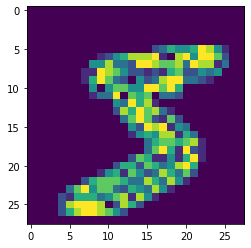

In [9]:
plt.imshow(((pattern-4)/4).reshape(28,28))

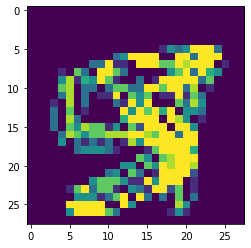

In [10]:
plt.imshow(torch.sum(out,dim=0))